# L4d: Kernel Regression in Finance
In this lab, we will implement kernel regression, a non-parametric method for regression analysis on time-series financial data. 

> __Learning Objectives__
> 
> By the end of this lab, you should be able to:
>
> Three learning objectives go here.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Data
We gathered a daily open-high-low-close dataset for each firm in the S&P 500 from `01-03-2014` until `12-31-2024`, along with data for a few exchange-traded funds and volatility products during that time. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [2]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    dataset = Dict{String,DataFrame}();
    for (ticker,data) ∈ original_dataset
        if (nrow(data) == maximum_number_trading_days)
            dataset[ticker] = data;
        end
    end
    dataset
end;

Finally, let's get a list of the firms in our cleaned dataset (and sort them alphabetically). We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable.

In [5]:
list_of_tickers = keys(dataset) |> collect |> sort # list of firm "ticker" symbols in alphabetical order

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 ⋮
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

### Compute the return matrix
Next, let's compute the return array which contains, for each day and each firm in our dataset, the value of the growth rate between time $j$ and $j-1$. 

>  __Continuously Compounded Growth Rate (CCGR)__
>
> Let's assume a model of the share price of firm $i$ is governed by an expression of the form:
>$$
\begin{align*}
S^{(i)}_{j} &= S^{(i)}_{j-1}\;\exp\left(\underbrace{g^{(i)}_{j,j-1}\Delta{t}_{j}}_{\text{return}}\right)
\end{align*}
$$
> where $S^{(i)}_{j-1}$ denotes the share price of firm $i$ at time index $j-1$, $S^{(i)}_{j}$ denotes the share price of firm $i$ at time index $j$, and $\Delta{t}_{j} = t_{j} - t_{j-1}$ denotes the length of a time step (units: years) between time index $j-1$ and $j$. The value we are going to estimate is the return, which is the growth rate $g^{(i)}_{j,j-1}$ (units: inverse years) for each firm $i$ multiplied by the time step in the dataset. 

We've implemented [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.log_growth_matrix) which takes the cleaned dataset and a list of ticker symbols, and returns the growth rate array. Each row of the growth rate array is a time step, while each column corresponds to a firm from the `list_of_tickers::Array{String,1}` array. We can get the return by passing in a time-step value of `1`.

In [39]:
G = let

    # initialize -
    r̄ = 0.0; # assume the risk-free rate is 0
    Δt = (1/252); # time step size (units: years)

    # what are my input tickers?

    # compute the growth matrix -
    growth_rate_array = log_growth_matrix(dataset, list_of_tickers, Δt = Δt, 
        risk_free_rate = r̄); # other optional parameters are at their defaults
    
    growth_rate_array; # return
end;

In [44]:
G

2766×424 Matrix{Float64}:
 -0.877554    6.28105    -2.87097     …  -0.755391   0.245894  -1.00527
  2.81626     1.07149     1.39239         2.13832   -0.80279    0.986468
  3.31305     0.855597    0.00536803      0.109877   1.191     -2.58144
  0.646425   17.2599      1.69215         0.274716   3.1593    -0.368228
  1.81609     2.57961     3.31924         0.621677  -2.1687     4.40309
  0.61383    -3.96384    -0.79278     …  -0.862739  -1.90977   -3.11624
  2.86071    -0.483751    4.84573         1.7657    -1.77685   -1.0896
  2.04671     1.0135      1.90809         1.67597    4.44984   -0.137819
  1.31289     1.67413     0.107259       -1.50708   -2.13696    1.43784
  1.22016     6.12957     0.932578       -1.53202    2.87784   -1.43626
  ⋮                                   ⋱                        
 -4.36889     3.84443    -2.37452        -4.26011   -9.17906   -3.94641
 -2.51182    -2.60891   -10.1209         -3.03895   -7.07468   -7.14019
  2.21355     4.15066     7.27678         3.

___

## Task 1: Exponential Moving Average (EMA) of Growth Rates
In this task, we will compute the exponential moving average (EMA) of the share price for each firm in our dataset. The EMA is a type of moving average that gives more weight to recent prices, making it more responsive to new information.

Let's start by choosing a ticker symbol from our `list_of_tickers` variable and save it in the `my_ticker::String` variable.

In [30]:
my_ticker = "UPS"; # choose a ticker symbol from the list_of_tickers variable

Next, let's get the volume weighted average price (VWAP) for the ticker in our dataset and save it in the `vwap::Array{Float64,1}` variable. The VWAP is a trading benchmark that gives the average price a security has traded at throughout the day, based on both volume and price.

In [31]:
vwap = dataset[my_ticker][!, :volume_weighted_average_price] |> collect; # get the VWAP for the ticker in our dataset

> __What is an Exponential Moving Average (EMA)?__ An EMA is a type of moving average that places a greater weight and significance on the most recent data points. The formula for calculating the EMA at time $t$ is given by:
> $$
\begin{align*}
EMA_t &= \alpha \cdot P_t + (1 - \alpha) \cdot EMA_{t-1}\quad \text{for } t > N - 1\;\text{and}\;\alpha = \frac{2}{N + 1}\\
\end{align*}
$$
> where: $P_t$ is the price at time $t$, $EMA_{t-1}$ is the EMA at the previous time step, and $N$ is the number of periods, e.g., days over which the EMA is calculated. The smoothing factor $\alpha$ determines how much weight is given to the most recent price.


We'll store these moving averages in the `EMA_data::Array{Float64,2}` variable.

In [35]:
EMA_data_price, N = let

    # initialize -
    N = 252; # N-day EMA window size (units: days)
    S = vwap; # share price (USD/share) for the ticker in our dataset
    length_of_S = length(S); # number of trading days in our dataset for the ticker
    EMA_array = Array{Float64,2}(undef, length_of_S, 2); # col 1: time, col 2: EMA (USD/share)

    # compute: EMA smoothing factor -
    α = 2.0 / (N + 1.0); # short-term smoothing factor

    # warmup: initialize EMA_array with raw prices during warmup period -
    for t ∈ 1:(N - 1)
        EMA_array[t,1] = t; 
        EMA_array[t,2] = S[t]; # use raw price until enough data available
    end

    # compute: exponential moving averages -
    for t ∈ 1:length_of_S
        
        # short-term EMA: EMA(t) = α*P(t) + (1-α)*EMA(t-1)
        if t >= N
            EMA_array[t,1] = t;
            EMA_array[t,2] = α*S[t] + (1 - α)*EMA_array[t - 1, 2];
        end
    end

    EMA_array, N; # return the EMA data array and the window size N
end;

__Visualize:__ Plot the observed volume weighted average price alongside the exponential moving average. 

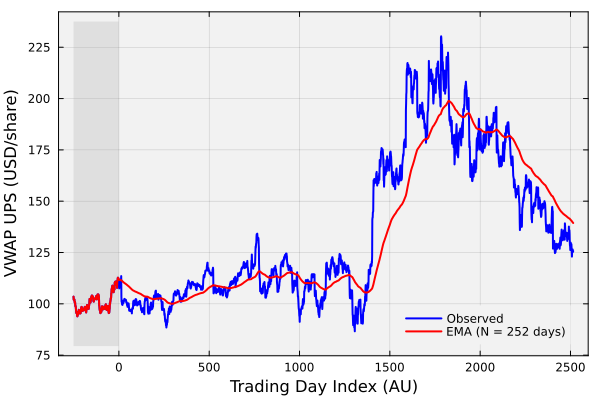

In [36]:
let

    # initialize -
    S = vwap; # share price (USD/share) for the ticker in our dataset 
    offset = N; # offset to account for moving average buffer
    data = EMA_data_price; # EMA data array
        
    # compute the "warmup box" for the pre-history period (time < 0)
    xvals = data[:,1] .- offset; # shifted time axis
    y_min, y_max = extrema(vcat(S, data[:,2])); # find min and max price for plotting
    y_pad = max(0.05 * (y_max - y_min), 1.0e-6);
    y_low = y_min - y_pad;
    y_high = y_max + y_pad;

    # plot with single shaded pre-history block (time < 0) -
    plt = plot(xlabel = "Time Step (Days)", ylabel = "Synthetic SPY Price (USD/share)");
    x_left = minimum(xvals);
    x_right = 0.0;
    plot!(plt, Shape([x_left, x_right, x_right, x_left], [y_low, y_low, y_high, y_high]);
          color = :darkgray, alpha = 0.25, linealpha = 0, label = false);


    plot!(data[:,1] .- offset, vwap, label="Observed", color=:blue, linewidth=2)
    plot!(data[:,1] .- offset, data[:,2], label="EMA (N = $(N) days)", color=:red, linewidth=2)
    plot!(plt, bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("Trading Day Index (AU)", fontsize=18)
    ylabel!("VWAP $(my_ticker) (USD/share)", fontsize=18)   
end

### Moving Average of Growth Rates
Next, let's compute the exponential moving average of the growth rates all the tickers in our dataset. We'll store these moving averages in the `EMA_growth_rates::NamedTuple` variable (we'll consider a short-term and long-term moving average, which will be array stored in the `short_term` and `long_term` fields of the named tuple, respectively).

In [ ]:
EMA_growth_rate_data, Nₒ, N₁ = let

    # initialize: allocate arrays for EMA time series -
    length_of_G = size(G,1); # total number of time steps - 1 (number of return measurements)
    Nₒ = 5; # short-term EMA window size (units: days)
    N₁ = 63; # long-term EMA window size (units: days)
    data = Dict{String, NamedTuple}(); # dictionary to hold EMA data for each ticker

    # compute: EMA smoothing factors (α = 2/(N+1)) -
    αₒ = 2.0 / (Nₒ + 1.0); # short-term smoothing factor
    α₁ = 2.0 / (N₁ + 1.0); # long-term smoothing factor 
    
    for ticker ∈ list_of_tickers

        # extract: growth rate time series for the ticker -
        ticker_index = findfirst(==(ticker), list_of_tickers); # index of the ticker in the list_of_tickers
        gᵢ = G[:, ticker_index]; # growth rate time series for the ticker

        # allocate new arrays for EMA time series -
        short_term_EMA = Array{Float64,2}(undef, length_of_G, 2); # col 1: time, col 2: EMA
        long_term_EMA = Array{Float64,2}(undef, length_of_G, 2); # col 1: time, col 2: EMA

        # warmup: initialize short-term EMA with raw prices during warmup period -
        for t ∈ 1:(Nₒ - 1)
            short_term_EMA[t,1] = t; 
            short_term_EMA[t,2] = gᵢ[t]; # use raw price until enough data available
        end
    
        # warmup: initialize long-term EMA with raw prices during warmup period -
        for t ∈ 1:(N₁ - 1)
            long_term_EMA[t,1] = t; 
            long_term_EMA[t,2] = gᵢ[t]; # use raw price until enough data available
        end
    

        # compute: exponential moving averages -
        for t ∈ 1:length_of_G
        
            # short-term EMA: EMA(t) = α*P(t) + (1-α)*EMA(t-1)
            if t >= Nₒ
                short_term_EMA[t,1] = t;
                short_term_EMA[t,2] = αₒ*gᵢ[t] + (1 - αₒ)*short_term_EMA[t - 1, 2];
            end

            # long-term EMA: EMA(t) = α*P(t) + (1-α)*EMA(t-1)
            if t >= N₁
                long_term_EMA[t,1] = t;
                long_term_EMA[t,2] = α₁*gᵢ[t] + (1 - α₁)*long_term_EMA[t - 1, 2];
            end
        end

        # return: named tuple with both EMA arrays -
        data[ticker] = (short_term_EMA = short_term_EMA, long_term_EMA = long_term_EMA);
    end

    (data, Nₒ, N₁); # return the EMA growth rate data dictionary and window sizes
end

(Dict{String, NamedTuple}("EMR" => (short_term_EMA = [1.0 -1.8129247285550365; 2.0 -0.6927924889913062; … ; 2765.0 -0.7486798593056255; 2766.0 -0.7101057404363664], long_term_EMA = [1.0 -1.8129247285550365; 2.0 -0.6927924889913062; … ; 2765.0 0.15113473159013407; 2766.0 0.12964545230529548]), "CTAS" => (short_term_EMA = [1.0 -1.3466239006335914; 2.0 0.5245424921707305; … ; 2765.0 -2.4067268790605567; 2766.0 -2.117305148410978], long_term_EMA = [1.0 -1.3466239006335914; 2.0 0.5245424921707305; … ; 2765.0 -0.9456913322812011; 2766.0 -0.9416043331626597]), "HSIC" => (short_term_EMA = [1.0 -0.8531578906889148; 2.0 3.701805599962907; … ; 2765.0 -1.3425980829079223; 2766.0 -1.2435464756909478], long_term_EMA = [1.0 -0.8531578906889148; 2.0 3.701805599962907; … ; 2765.0 -0.29282879614906643; 2766.0 -0.3086095913698632]), "KIM" => (short_term_EMA = [1.0 -0.23412254699062082; 2.0 1.3360022873946817; … ; 2765.0 -1.202086803734627; 2766.0 -0.5066010423871612], long_term_EMA = [1.0 -0.234122546990

In [48]:
Z = EMA_growth_rate_data["AAPL"]

(short_term_EMA = [1.0 -1.9954223478275546; 2.0 0.15124876922831154; … ; 2765.0 0.41020565605063325; 2766.0 0.2329287914117611], long_term_EMA = [1.0 -1.9954223478275546; 2.0 0.15124876922831154; … ; 2765.0 0.4992586799183259; 2766.0 0.4355368507028482])

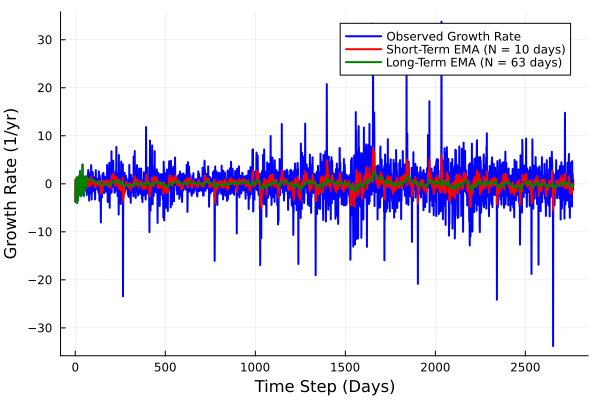

In [57]:
let

    # initialize -
    ema_data = EMA_growth_rate_data[my_ticker];
    i = findfirst(==(my_ticker), list_of_tickers); # index of the ticker in the list_of_tickers
    gᵢ = G[:, i]; # actual growth rate time series for the ticker


    # plot base -
    plot(gᵢ, label="Observed Growth Rate", color=:blue, linewidth=2,
         xlabel = "Time Step (Days)", ylabel = "Growth Rate (1/yr)");

    # plot short-term EMA -
    short_term_EMA = ema_data.short_term_EMA;
    plot!(short_term_EMA[:,1], short_term_EMA[:,2], label="Short-Term EMA (N = $(Nₒ) days)", color=:red, linewidth=2);

    # plot long-term EMA -
    long_term_EMA = ema_data.long_term_EMA;
    plot!(long_term_EMA[:,1], long_term_EMA[:,2], label="Long-Term EMA (N = $(N₁) days)", color=:green, linewidth=2);
end

## Task 2: Kernel Regression for Stock Price Simulation
Fill me in

## Summary
One direct, concise summary sentence goes here.

> __Key Takeaway__
>
> Three key takeaways go here.

One direct, concise concluding sentence goes here.
___